In [ ]:
using DataFrames
using LinearAlgebra
using JuMP
using LightGraphs, SimpleWeightedGraphs
using MathOptInterfaceMosek
using MathOptInterface

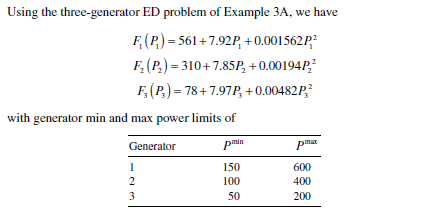

In [ ]:
Gen = DataFrame(a = [0.001562, 0.00194, 0.00482], 
                b = [7.92, 7.85, 7.97],
                c = [561, 310, 78],
                Pmax = [600, 400, 200],
                Pmin = [150, 100, 50]);

In [ ]:
size(Gen,2)

In [ ]:
Gw = SimpleWeightedGraph(3)
add_edge!(Gw,1,2,1/0.1)
add_edge!(Gw,1,3,1/0.125)
add_edge!(Gw,2,3,1/0.2)
Aw = Array(weights(Gw))
Lw = Diagonal(sum(Aw,dims=1)[:])-Aw
B = Lw;

In [ ]:
Load = DataFrame(L= [200.0, 550.0, 100.0]);

In [ ]:
LineLimit = [150, 1000, 1000]

In [ ]:
model = Model(with_optimizer(MosekOptimizer, QUIET=false, INTPNT_CO_TOL_DFEAS=1e-7))

In [ ]:
@variable(model, P[1:3])
@variable(model, u[1:3],Bin)
@variable(model, θ[1:3])
fix( θ[1], 0, force = true)

In [ ]:
@objective(model,Min, sum(Gen.a[i]*P[i]^2 + Gen.b[i]*P[i] + Gen.c[i] for i in 1:3))

In [ ]:
@constraint(model,LoadBalance, sum(Load.L[i] for i in 1:3) == sum(P[i] for i in 1:3))

In [ ]:
@constraint(model,PowerFlow[i = 1:3], sum(100 * B[i,j] * (θ[i] - θ[j]) for j in 1:3) == P[i]  - Load.L[i] )

In [ ]:
@constraint(model,MaxPowerLimits[i = 1:3],  P[i] <= Gen.Pmax[i]*u[i])
@constraint(model,MinPowerLimits[i = 1:3],  P[i] >= Gen.Pmin[i]*u[i])

In [ ]:
@constraint(model,MaxLineLimit[i = 1:3],sum(100 * B[i,j] * (θ[i] - θ[j]) for j in 1:3) <=  LineLimit[i])
@constraint(model,MinLineLimit[i = 1:3],sum(100 * B[i,j] * (θ[i] - θ[j]) for j in 1:3) >= -LineLimit[i])

In [ ]:
model

In [ ]:
optimize!(model)

In [ ]:
I=objective_bound(model)

In [ ]:
100*B[1,2]*(value(θ[1])-value(θ[2]))

In [ ]:
100*B[1,3]*(value(θ[1])-value(θ[3]))

In [ ]:
100*B[2,3]*(value(θ[2])-value(θ[3]))